# NLP 


In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# for handling accented characters (Á to A)
from unidecode import unidecode

# to get list of punctuations
from string import punctuation

# nltk libraries 
from nltk.tokenize import word_tokenize # to make tokens (sentense/words)
from nltk.corpus import stopwords # to get list of stopwords
from nltk.stem import WordNetLemmatizer # to find root words


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from xgboost import XGBClassifier

# to balance the data
from imblearn.over_sampling import SMOTE

In [2]:
data = pd.read_csv("./data/spam.csv")

In [3]:
data

,CATEGORY,MESSAGE,FILE_NAME
0,1,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",00249.5f45607c1bffe89f60ba1ec9f878039a
1,1,ATTENTION: This is a MUST for ALL Computer Use...,00373.ebe8670ac56b04125c25100a36ab0510
2,1,This is a multi-part message in MIME format.\n...,00214.1367039e50dc6b7adb0f2aa8aba83216
3,1,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,00210.050ffd105bd4e006771ee63cabc59978
4,1,This is the bottom line. If you can GIVE AWAY...,00033.9babb58d9298daa2963d4f514193d7d6
...,...,...,...
5791,0,"I'm one of the 30,000 but it's not working ver...",00609.dd49926ce94a1ea328cce9b62825bc97
5792,0,Damien Morton quoted:\n\n>W3C approves HTML 4 ...,00957.e0b56b117f3ec5f85e432a9d2a47801f
5793,0,"On Mon, 2002-07-22 at 06:50, che wrote:\n\n\n\...",01127.841233b48eceb74a825417d8d918abf8
5794,0,"Once upon a time, Manfred wrote :\n\n\n\n> I w...",01178.5c977dff972cd6eef64d4173b90307f0


In [4]:
data.dtypes

CATEGORY      int64
MESSAGE      object
FILE_NAME    object
dtype: object

In [5]:
data.isna().sum()

CATEGORY     0
MESSAGE      0
FILE_NAME    0
dtype: int64

In [6]:
# Defining the function to detect languages
# If we have empty string so langdetect will give error. So, I am using try except.
def lang_detect(data):
    m = ""
    try:
        m = detect(data)
    except:
        pass
    return m
s = pd.Series(data["MESSAGE"].apply(lang_detect))
s.unique()

array([''], dtype=object)

<AxesSubplot:xlabel='CATEGORY', ylabel='count'>

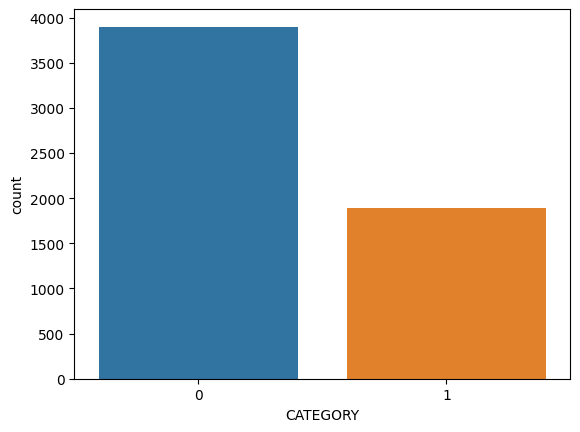

In [7]:
sns.countplot(data["CATEGORY"])

In [8]:
data["CATEGORY"].value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [9]:
# On part du principe que la categorie 1 == SPAM et categorie 0 == NO SPAM

In [10]:
def standardize_text(df, content_field):
    df[content_field] = df[content_field].str.replace(r"http\S+", "")
    df[content_field] = df[content_field].str.replace(r"http", "")
    df[content_field] = df[content_field].str.replace(r"@\S+", "")
    df[content_field] = df[content_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[content_field] = df[content_field].str.replace(r"@", "at")
    df[content_field] = df[content_field].str.replace(r"\n", " ")
    df[content_field] = df[content_field].str.replace(r"_", "")
    df[content_field] = df[content_field].str.replace(r"\\", "")
    df[content_field] = df[content_field].str.lower()
    return df

In [11]:
standardize_text(data,"MESSAGE")

,CATEGORY,MESSAGE,FILE_NAME
0,1,"dear homeowner, interest rates are at thei...",00249.5f45607c1bffe89f60ba1ec9f878039a
1,1,attention this is a must for all computer use...,00373.ebe8670ac56b04125c25100a36ab0510
2,1,this is a multi part message in mime format ...,00214.1367039e50dc6b7adb0f2aa8aba83216
3,1,important information the new domain names...,00210.050ffd105bd4e006771ee63cabc59978
4,1,this is the bottom line if you can give away...,00033.9babb58d9298daa2963d4f514193d7d6
...,...,...,...
5791,0,"i'm one of the 30,000 but it's not working ver...",00609.dd49926ce94a1ea328cce9b62825bc97
5792,0,damien morton quoted w3c approves html 4 'e...,00957.e0b56b117f3ec5f85e432a9d2a47801f
5793,0,"on mon, 2002 07 22 at 06 50, che wrote t...",01127.841233b48eceb74a825417d8d918abf8
5794,0,"once upon a time, manfred wrote i would...",01178.5c977dff972cd6eef64d4173b90307f0


In [12]:
data['LENGTH'] = data['MESSAGE'].apply(len)
data.head()

,CATEGORY,MESSAGE,FILE_NAME,LENGTH
0,1,"dear homeowner, interest rates are at thei...",00249.5f45607c1bffe89f60ba1ec9f878039a,525
1,1,attention this is a must for all computer use...,00373.ebe8670ac56b04125c25100a36ab0510,1217
2,1,this is a multi part message in mime format ...,00214.1367039e50dc6b7adb0f2aa8aba83216,6000
3,1,important information the new domain names...,00210.050ffd105bd4e006771ee63cabc59978,1012
4,1,this is the bottom line if you can give away...,00033.9babb58d9298daa2963d4f514193d7d6,1742


In [13]:
data.describe()

,CATEGORY,LENGTH
count,5796.000000,5796.000000
mean,0.327122,2580.861284
std,0.469203,6760.430935
min,0.000000,1.000000
25%,0.000000,565.000000
50%,0.000000,1088.500000
75%,1.000000,2325.250000
max,1.000000,234168.000000
